In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [13]:
!ls "/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints"

'4. Fun with Keypoints.ipynb'   images	    moi.jpg	       saved_models
 data			        LICENSE     __pycache__        test2.jpg
 detector_architectures         models.py   README.md
 Facial_keypoints.ipynb         moi2.jpg    requirements.txt


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models
import torch.optim as optim

 #### Some transform from scratch because we need to transform also the keypoints
 
 - Normalize
 - Rescale
 - RandomCrop
 - Totensor

In [0]:
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image_copy =  image_copy/255.0
            
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = np.copy(key_pts)
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        # Grab height and width of the image
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}

In [0]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [0]:
batch_size = 128 #128 in the paper but collab run out of memory
num_workers = 4
csv_file = '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/data/training_frames_keypoints.csv'
root_dir = '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/data/training/'

transform = transforms.Compose([
    Rescale(256),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

In [0]:
train_set = FacialKeypointsDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

In [0]:
def train_valid_split(training_set, validation_size):
    """ Function that split our dataset into train and validation
        given in parameter the training set and the % of sample for validation"""
    
    # obtain training indices that will be used for validation
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return train_sampler, valid_sampler


valid_size = 0.3
train_sampler, valid_sampler = train_valid_split(train_set, valid_size)

In [0]:
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                          num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler,
                                           num_workers=num_workers)

#### Visualize

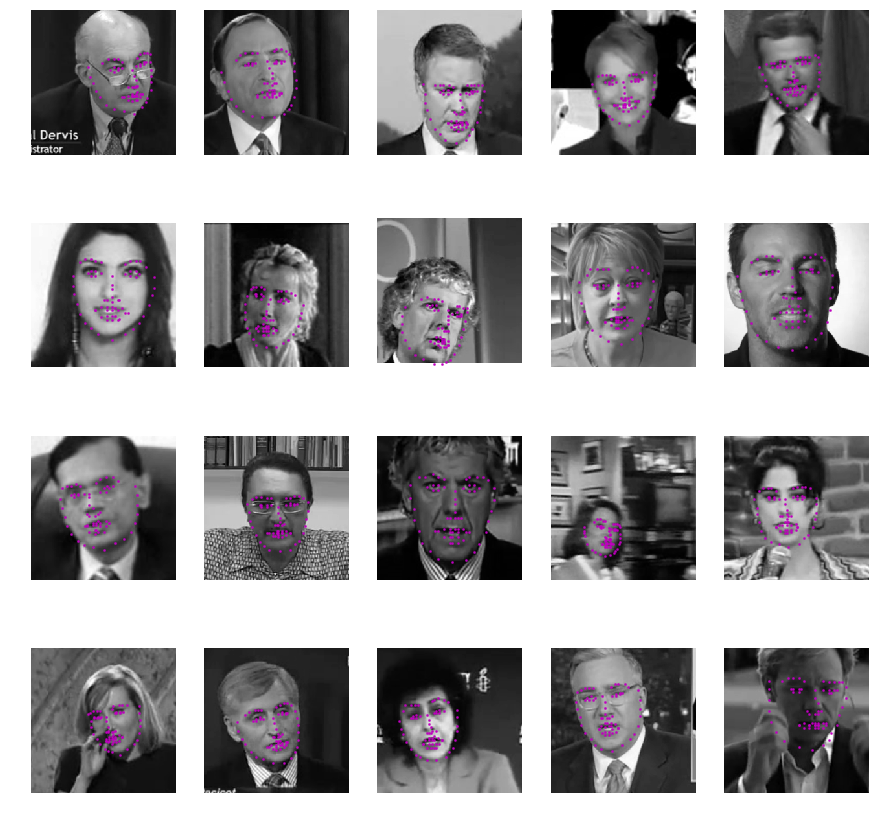

In [24]:
plt.figure(figsize=(15,15))

# obtain one batch of training images
batch = next(iter(train_loader))

# display 20 images
for i in np.arange(20):
    
    images, labels = batch['image'], batch['keypoints']
    
    #unormalize images
    image = images[i].numpy()
    image = np.transpose(image, (1, 2, 0))
     
    #unormalize labels
    labels = labels[i].numpy()
    labels = labels*50.0+100
    
    plt.subplot(4,5,i+1)
    plt.imshow(np.squeeze(image), cmap='gray')
    plt.scatter(labels[:, 0], labels[:, 1], s=20, marker='.', c='m')
    plt.axis('off')

## Network

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2) #(window size, stride)
                
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4) #224, 32
        
        self.conv2 = nn.Conv2d(32, 64, 3) #112, 64
        
        self.conv3 = nn.Conv2d(64, 128, 2) #56, 128
        
        self.conv4 = nn.Conv2d(128, 256, 1) #28, 256
        
        self.fc1 = nn.Linear(43264, 1000)   #36864
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 136)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.3)
        self.drop4 = nn.Dropout(p = 0.4)
        self.drop5 = nn.Dropout(p = 0.5)
        self.drop6 = nn.Dropout(p = 0.6)
        
        

        
    def forward(self, x):
      
      
        x = self.drop1(self.pool(F.relu(self.conv1(x))))
        x = self.drop2(self.pool(F.relu(self.conv2(x))))
        x = self.drop3(self.pool(F.relu(self.conv3(x))))
        x = self.drop4(self.pool(F.relu(self.conv4(x))))
        
        x = x.view(x.size(0), -1)
        
        x = self.drop5(F.relu(self.fc1(x)))
        x = self.drop6(F.relu(self.fc2(x)))
        
        x = self.fc3(x)
        
        return x


In [26]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA not available... Training on CPU')
else:
    print('CUDA available... Training on GPU')

CUDA available... Training on GPU


In [27]:
model = Net()

print(f"input features: {model.fc1.in_features}") 
print(f"output features: {model.fc3.out_features}")

input features: 43264
output features: 136


In [0]:
if train_on_gpu:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001, betas=(0.9, 0.999), eps=1e-08)

#model 0.001 bs 64
#model2 0.0001 bs 64

#try model with 0.001 and batch size 128

#### Train

In [33]:
n_epochs = 300

valid_loss_min = np.Inf

model.train()

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    for data in train_loader:
        
        # Grab the image and its corresponding label
        images = data['image']
        key_pts = data['keypoints']
      
        if train_on_gpu:
            images, key_pts = images.cuda(), key_pts.cuda()
        
        
        # Flatten keypoints & convert data to FloatTensor for regression loss
        key_pts = key_pts.view(key_pts.size(0), -1)
        key_pts = key_pts.type(torch.cuda.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)
                  
        
        optimizer.zero_grad()                           # Clear the gradient        
        output = model(images)                          # Forward
        loss = criterion(output, key_pts)               # Compute the loss
        loss.backward()                                 # Compute the gradient
        optimizer.step()                                # Perform updates using calculated gradients
        
        train_loss += loss.item()*images.size(0)




    # Validation
    model.eval()
    for data in valid_loader:
        
        images = data['image']
        key_pts = data['keypoints']

        if train_on_gpu:
            images, key_pts = images.cuda(), key_pts.cuda()
        
        
        key_pts = key_pts.view(key_pts.size(0), -1)
        key_pts = key_pts.type(torch.cuda.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)
        
        output = model(images)
        loss = criterion(output, key_pts)
        
        valid_loss += loss.item()*images.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # print training/validation statistics 
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}")

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...")
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/saved_models/model2_128_bs.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 27.748493062822444 	Validation Loss: 24.30718586842219
Validation loss decreased (inf --> 24.30718586842219).  Saving model ...
Epoch: 2 	Training Loss: 26.96984088420868 	Validation Loss: 26.24853213628133
Epoch: 3 	Training Loss: 26.00559857644533 	Validation Loss: 25.155839598841137
Epoch: 4 	Training Loss: 26.469734405216418 	Validation Loss: 26.256630924012924
Epoch: 5 	Training Loss: 27.395405832089875 	Validation Loss: 25.005815631813473
Epoch: 6 	Training Loss: 26.462201645499782 	Validation Loss: 28.848086847199333
Epoch: 7 	Training Loss: 26.54283150246269 	Validation Loss: 27.16213767727216
Epoch: 8 	Training Loss: 26.472427769711143 	Validation Loss: 26.55335644218657
Epoch: 9 	Training Loss: 27.370659583493282 	Validation Loss: 26.347334540552563


KeyboardInterrupt: ignored

In [0]:
!ls '/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/saved_models'

description.txt  model2.pt  model.pt


In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/saved_models/model2.pt', map_location='cpu'))
print("Model succefully loaded !")
model.eval()

Model succefully loaded !


Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
)

In [0]:
def rescale_img(image, output_size):
  
    h, w = image.shape[:2]

    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w, new_h))

    return img
      
  
  
  
def normalize_img(image):
  
    image_copy = np.copy(image)
    image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_copy =  image_copy/255.0

    return image_copy
  
  

def tensor_img(image):

    # if image has no grayscale color channel, add one
    if(len(image.shape) == 2):
        # add that third color dim
        image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))

    return torch.from_numpy(image)

### select region of interest

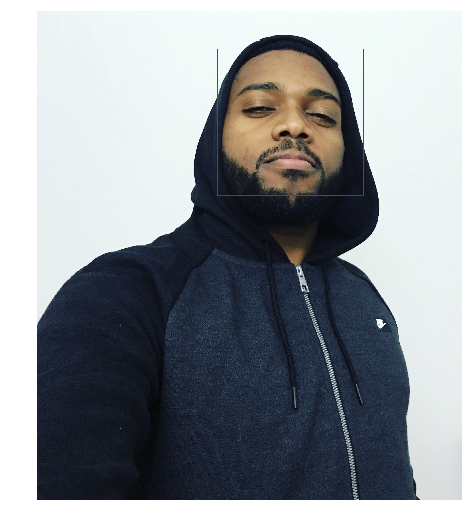

In [0]:
# Detect Face in an Image using Cascade File

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/moi2.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_detection = image.copy()


face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/detector_architectures/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(img_detection, scaleFactor=1.2, minNeighbors=2)


for (x,y,w,h) in faces:
    
    cv2.rectangle(img_detection,(x,y),(x+w,y+h),(255,0,0),3)

    

fig = plt.figure(figsize=(9,9))

plt.axis('off')

plt.imshow(img_detection)



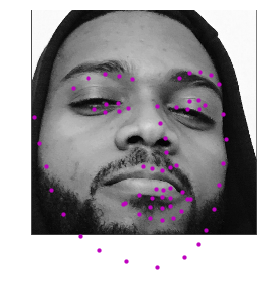

In [0]:
plt.figure(figsize=(5,5))

model.cpu()

# Loop over the detected faces
# Keep the face part using cropping
# Predict keypoint
for (x,y,w,h) in faces:
  
    image_kpts = img_detection[y:y+h, x:x+w]  
    

image_kpts = cv2.resize(image_kpts, (224,224))

image_kpts = normalize_img(image_kpts)

image_kpts = tensor_img(image_kpts)


# convert images to FloatTensors
image_kpts = image_kpts.type(torch.FloatTensor)

# forward pass to get model output
with torch.no_grad():
    output_pts = model(image_kpts.unsqueeze(0))

# reshape to batch_size x 68 x 2 pts
output_pts = output_pts.view(output_pts.size()[0], 68, -1)

#unormalize images
image_kpts = image_kpts.numpy()
image_kpts = np.transpose(image_kpts, (1, 2, 0))


#unormalize labels
labels = output_pts.numpy()
labels = labels*50.0+100
labels = labels.reshape(-1, 2)


#plt.subplot(4,5,i+1)
plt.axis('off')
plt.imshow(np.squeeze(image_kpts), cmap='gray')
plt.scatter(labels[:, 0], labels[:, 1], s=60, marker='.', c='m')

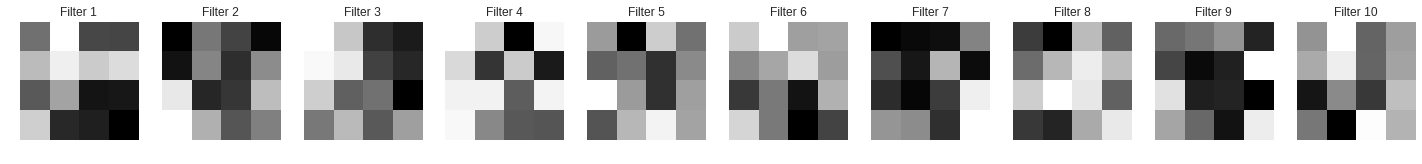

In [0]:
plt.figure(figsize=(25,20))

# weight of the first conv layer
weights1 = model.conv1.weight.data
w = weights1.numpy()

#plot the first 10 filters
for i in range(10):
  #choose a filter
  num_filter = i

  filter = w[num_filter][0]
  
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  
  plt.title(f"Filter {i+1}")
  plt.imshow(filter, cmap='gray')

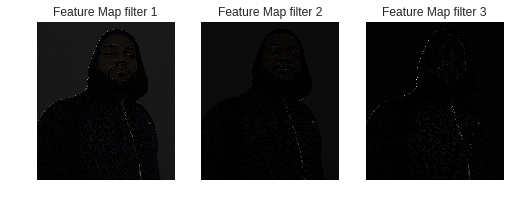

In [0]:
plt.figure(figsize=(29,20))

# Let's visualize some features maps

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/moi2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(image)
#plt.title("Orginal Image")

weights1 = model.conv1.weight.data
w = weights1.numpy()

# Applying the image
for i in range(3):
  num_filter = i
  
  filtered = cv2.filter2D(image, -1, w[num_filter][0])
  
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  
  plt.title(f"Feature Map filter {i+1}")
  plt.imshow(filtered)

#### Let's do some Funny stuff

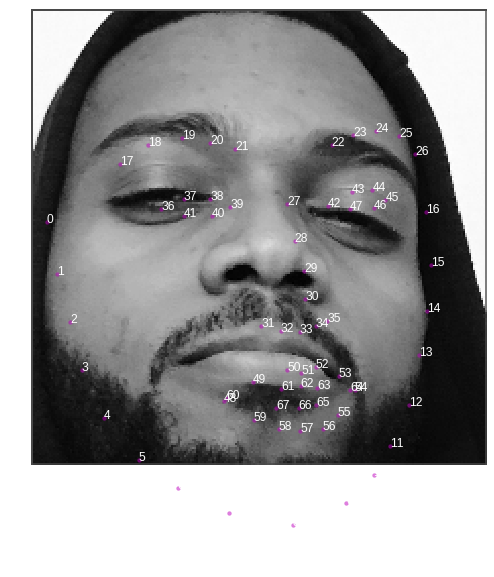

In [0]:
# Keypoints position

plt.figure(figsize=(10,10))

plt.axis('off')
plt.imshow(np.squeeze(image_kpts), cmap='gray')
plt.scatter(labels[:, 0], labels[:, 1], s=60, marker='.', c='m', alpha = 0.5)

for i in range(labels.shape[0]):
    plt.text(labels[i,0], labels[i,1], str(i), color='white')

Image shape:  (1123, 3064, 4)
The alpha channel looks like this (black pixels = transparent): 


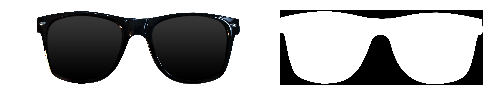

In [0]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED because we want to read the alpha channel png
sunglasses = cv2.imread('/content/drive/My Drive/Colab Notebooks/P1_Facial_Keypoints/images/sunglasses.png', cv2.IMREAD_UNCHANGED)

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(sunglasses)
print('Image shape: ', sunglasses.shape)

# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(alpha_channel, cmap='gray')
print ('The alpha channel looks like this (black pixels = transparent): ')


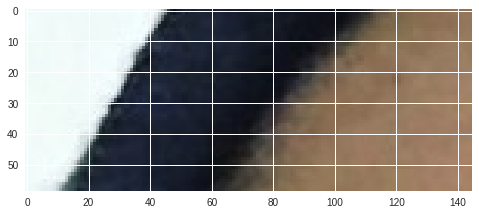

In [0]:
for (x,y,w,h) in faces:
    img = img_detection[y:y+h, x:x+w]


# point (x,y) representant la pointe du sourcil gauche
x = int(labels[17, 0])
y = int(labels[17, 1])


# h and w that we want for the sunglasse
h = int(abs(labels[27,1] - labels[34,1]))
w = int(abs(labels[17,0] - labels[26,0]))


new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

# get region of interest on the face to change
roi_color = img[y:y+h,x:x+w]

plt.imshow(roi_color)

In [0]:
print(y, y+h, x, x+w)

85 130 50 168


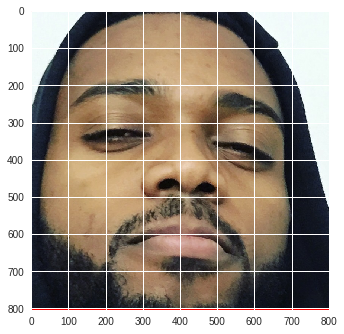

In [0]:
plt.imshow(img)